# Intersect population data with flooding data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import pandas as pd
import rioxarray as rx
import geowombat as gw
import matplotlib.pyplot as plt
from shapely.geometry import box

c:\Users\AMarley.ERG\.conda\envs\geospatial-new\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# data paths
RAW_DATA = "../data/raw/"
CLEAN_DATA = "../data/clean/"
SLAMM_RESULTS = CLEAN_DATA + "slamm/"
OUTPUT = "../output/"

Make bounding box extent for census data

In [6]:
# State census block paths
ri_blocks = RAW_DATA + 'census/ri_census_2020/US_Census_Blocks_v1_-452236390224518097.geojson'
ma_blocks = RAW_DATA + "census/ma_census_2020/CENSUS2020BLOCKS_POLY.shp"

In [7]:
# Crop to the census blocks in the saltmarsh area
def get_aoi_cblocks(state_cblocks_path:str, sm_buffer_path:str, which_crs, which_marsh:str): 
    
    # read in data
    state_blocks = gpd.read_file(state_cblocks_path).to_crs(which_crs)
    sm_buffer = gpd.read_file(sm_buffer_path).to_crs(which_crs)

    # create bounding box
    minx, miny, maxx, maxy = sm_buffer.total_bounds
    bbox = box(minx, miny, maxx, maxy)
    sm_ext = gpd.GeoDataFrame([[bbox]], columns=['geometry'], crs=sm_buffer.crs)
    sm_ext['geometry'] = sm_ext.geometry.buffer(600)

    # save the extent
    sm_ext.to_file(CLEAN_DATA + "chosen_saltmarshes/" + which_marsh + "_extent_buffer.shp")

    # crop the data
    sm_blocks = gpd.clip(state_blocks, sm_ext)

    # Add area column
    sm_blocks['area_m2'] = sm_blocks.geometry.area

    # save the data
    sm_blocks.to_file(CLEAN_DATA + "chosen_saltmarshes/" + which_marsh + "_blocks.shp")

    return sm_blocks

In [31]:
ma2_buffer = CLEAN_DATA + "chosen_saltmarshes/MA-2_buffer.shp"
ma2_blocks = get_aoi_cblocks(ma_blocks, ma2_buffer, 3857, "ma2")

In [8]:
ri2_buffer = CLEAN_DATA + "chosen_saltmarshes/RI-2_buffer.shp"
ri2_blocks = get_aoi_cblocks(ri_blocks, ri2_buffer, 26918, "ri2")

Calculate total number of people in census blocks considered

In [30]:
ma2_blocks = gpd.read_file(CLEAN_DATA + 'chosen_saltmarshes/ma2_blocks.shp')
cc1_blocks = gpd.read_file(CLEAN_DATA + 'chosen_saltmarshes/cc1_blocks.shp')
ri2_blocks = gpd.read_file(CLEAN_DATA + 'chosen_saltmarshes/ri2_blocks.shp')

In [34]:
print(f"MA2 population: {ma2_blocks.POP20.sum()}")
print(f"CC1 population: {cc1_blocks.POP20.sum()}")
print(f"RI2 population: {ri2_blocks.POP20.sum()}")

MA2 population: 43817.0
CC1 population: 25698.0
RI2 population: 48641


Calculate the number of people affected by each flooding frequency

In [4]:
# function to intersect the flooding geodataframe with the census block data
def intersect_blocks(inun_path: str, census_path: str):

    # read in sm results
    inun_gdf = gpd.read_file(inun_path)

    # read in and simplify the census block data
    census_blocks = gpd.read_file(census_path)
    census_blocks = census_blocks[['GEOID20', 'POP20', 'area_m2', 'geometry']]
    census_blocks = census_blocks.to_crs(inun_gdf.crs)

    # intersect census block data with the flooding data
    intersected = gpd.overlay(census_blocks, inun_gdf, how='intersection')
    intersected['intersect_area'] = intersected.geometry.area
    intersected['fract_inundated'] = intersected['intersect_area'] / intersected['area_m2']
    intersected['pop_affected'] = intersected['fract_inundated'] * intersected['POP20']
    intersected.drop('geometry', axis = 1, inplace=True)
    group_pop = intersected.groupby(by = 'inun_freq').agg(
        {'year': 'first', 
         'marsh': 'first',
         'pop_affected': "sum"
         }
         ).reset_index()
    
    return group_pop

In [5]:
import glob
from tqdm.auto import tqdm
import re

In [6]:
FILE_PATH_PATTERN = re.compile(r"(cc1|ma2|ri2)\/.*(1|2)slr_.*(20|70|40)_(n|s).*\.geojson", re.IGNORECASE)
pbar = tqdm(glob.glob(f"{SLAMM_RESULTS}/*/*.geojson"))

ri2_combined=None
cc1_combined=None
ma2_combined=None
for fpath in pbar:
    fpath = fpath.replace("\\", "/")
    pbar.set_description(f"Processing {fpath.split('/')[-1]}")
    match = FILE_PATH_PATTERN.search(fpath)
    if match is None:
        continue
    marsh_id = match.group(1)
    slr_scenario = match.group(2)

    if marsh_id == 'cc1':
        intersected_cc1 = intersect_blocks(fpath, CLEAN_DATA + 'chosen_saltmarshes/cc1_blocks.shp')
        intersected_cc1['slr_m'] = slr_scenario
        if cc1_combined is None:
            cc1_combined = intersected_cc1
        else:
            cc1_combined = pd.concat([cc1_combined, intersected_cc1])

    if marsh_id == 'ma2':
        intersected_ma2 = intersect_blocks(fpath, CLEAN_DATA + 'chosen_saltmarshes/ma2_blocks.shp')
        intersected_ma2['slr_m'] = slr_scenario
        if ma2_combined is None:
            ma2_combined = intersected_ma2
        else:
            ma2_combined = pd.concat([ma2_combined, intersected_ma2])

    if marsh_id == 'ri2':
        intersected_ri2 = intersect_blocks(fpath, CLEAN_DATA + 'chosen_saltmarshes/ri2_blocks.shp')
        intersected_ri2['slr_m'] = slr_scenario
        if ri2_combined is None:
            ri2_combined = intersected_ri2
        else:
            ri2_combined = pd.concat([ri2_combined, intersected_ri2])
        
cc1_combined.to_csv(SLAMM_RESULTS + 'intersections/cc1_pop_affect.csv')
ma2_combined.to_csv(SLAMM_RESULTS + 'intersections/ma2_pop_affect.csv')
ri2_combined.to_csv(SLAMM_RESULTS + 'intersections/ri2_pop_affect.csv')

Processing ri2_2slr_70_sm_00.geojson: 100%|██████████| 35/35 [52:47<00:00, 90.51s/it]  


Plot it

In [4]:
import matplotlib.pyplot as plt
from util import plot_stack_bar

In [24]:
combined_slr = pd.read_csv(SLAMM_RESULTS + 'intersections/ma2_pop_affect.csv')

In [6]:
# Make inundation frequency key to add to dataframe
inun_freq_key_list = [
    [0, 'always inundated'], 
    [1, '30-day inundation'], 
    [2, '60-day inundation'], 
    [3, '90-day inundation'], 
    [4, '10-year storm'], 
    [5, '100-year storm'], 
    [8, 'protected by dikes']
]

inun_freq_key_df = pd.DataFrame(inun_freq_key_list, columns=['inun_freq_code', 'inun_freq'])

In [28]:
combined_wanted = combined_slr[combined_slr['year']==2040]
combined_wanted = combined_wanted[combined_wanted['slr_m']==1]
combined_wanted = combined_wanted.merge(inun_freq_key_df, on='inun_freq', how='left')
combined_wanted['pop_affected_thousands'] = combined_wanted['pop_affected'] / 1000

inun_freq_leg,10-year storm surge,100-year storm surge,Always,At least every 30-days,At least every 60-days,At least every 90-days
marsh,,,,,,
Marsh\npresent,4.668448,9.787433,0.366771,0.476746,6.458227e-07,0.901994
No\nmarsh,4.540845,9.753104,1.838010,0.073900,6.458227e-07,NaN


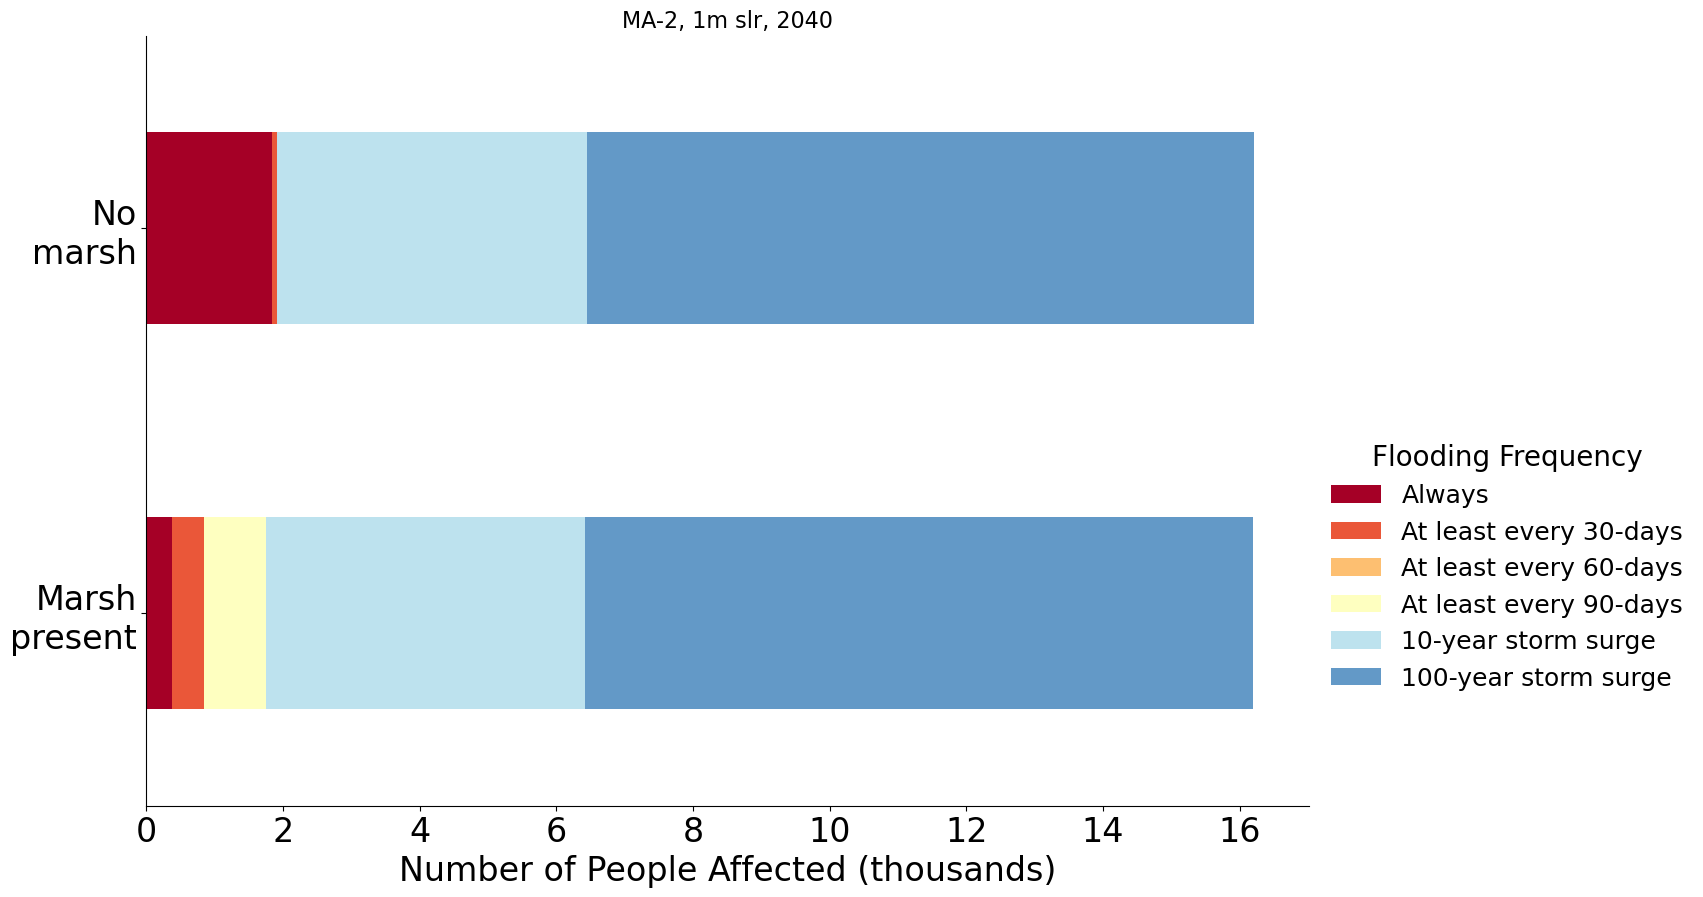

In [29]:
plot_stack_bar(combined_wanted, 
               'pop_affected_thousands', 
               "MA-2, 1m slr, 2040", 
               'Number of People Affected (thousands)', 
               OUTPUT + 'ma2/ma2_pop_1m_40_thous.png')